In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [26]:
from pydantic import BaseModel
from playwright.async_api import Page
from langgraph.graph import MessagesState
from typing import Literal, List, TypedDict, Annotated
from operator import add


class Bbox(TypedDict):
    id: int
    x: float
    y: float
    type: str
    text: str
    arialabel: str

class ImageScreenShoot(TypedDict):
    img : str
    bboxes : List[Bbox]

class Action(TypedDict):
    action: Literal["click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "press_enter"]
    text_to_type: str
    bbox: Bbox

class AnswerNode(TypedDict):
    answer: str

class MasterPlanState(TypedDict):
    plan: List[str]
    search_page: Literal["yes", "no"]

class CurrentPlanState(TypedDict):
    plan: List[str]

class ToolAndBboxActionList(TypedDict):
    tool_list: List[Action]

class AgentState(MessagesState):
    task: str
    page: Page
    master_plan: MasterPlanState
    current_plan: CurrentPlanState
    tool_and_bbox_action: ToolAndBboxActionList
    last_tool_action: str
    next_tool_action: Action
    answer: AnswerNode
    notes: Annotated[List[str], add]
    status: Literal["in_progress", "completed"]


In [27]:
import base64
import asyncio
from playwright.async_api import async_playwright
import asyncio
from PIL import Image as PILImage
import io


with open("mark_page.js") as f:
    mark_page_script = f.read()


async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range (10):
        try: 
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            asyncio.sleep(3)
    # Get screenshot as bytes
    screenshot_bytes = await page.screenshot(path="screenshot.png")
    
    # Convert to PIL Image
    img = PILImage.open(io.BytesIO(screenshot_bytes))
    # Convert to grayscale to reduce color information
    img = img.convert('L')
    
    # Resize image (adjust dimensions as needed)
    max_size = (300, 300)  # You can adjust these dimensions
    img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
    
    # Quantize the image to reduce number of colors
    img = img.quantize(colors=16)  # Reduce to 16 colors
    img = img.convert('L')  # Convert back to grayscale before JPEG saving

    # Save with compression
    buffer = io.BytesIO()
    img.save(buffer, format='JPEG', quality=5,  # Reduced quality
                optimize=True,  # Enable additional optimization
                progressive=True)  # Use progressive encoding
    compressed_bytes = buffer.getvalue()
    await page.evaluate("unmarkPage()")
    return ImageScreenShoot(img = base64.b64encode(compressed_bytes).decode("utf-8"), bboxes=bboxes)



In [28]:
from langchain_core.tools import Tool
from langchain_core.tools import StructuredTool
from langchain_core.messages import AIMessage, HumanMessage
import platform

async def click_element(agent_state: AgentState):
    """Click on a specified element on the webpage using its bounding box coordinates.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    """
    print("********************CLICK ELEMENT TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    print(f"Page: {page}")
    print("----------------------------------------------------------\n")
    next_tool_action = agent_state["next_tool_action"]
    print(f"Next Tool Action: {next_tool_action}")
    print("----------------------------------------------------------\n")
    bbox = next_tool_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    await page.mouse.click(bbox["x"], bbox["y"])
    sleep_time = 2
    await asyncio.sleep(sleep_time)
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    return {"messages": [AIMessage(content=f"clicked element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"click_element with id {bbox_id} and text {bbox_text}"} # Return string, not dict

async def scroll_element(agent_state: AgentState):
    """Scroll the webpage up or down.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
   
    """
    print("********************SCROLL TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    next_tool_action = agent_state["next_tool_action"]
    print(f"Next Tool Action: {next_tool_action}")
    print("----------------------------------------------------------\n")
    bbox = next_tool_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    await page.mouse.wheel(0, 200)
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    sleep_time = 0.5
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"scrolled element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"scroll_element with id {bbox_id} and text {bbox_text}"} # Return string, not dict

async def type_text(agent_state: AgentState):
    """Type text into a specified element on the webpage.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    
    """
    print("********************TYPE TEXT TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    print(f"Page: {page}")
    print("----------------------------------------------------------\n")
    next_tool_action = agent_state["next_tool_action"]
    print(f"Next Tool Action: {next_tool_action}")
    print("----------------------------------------------------------\n")
    bbox = next_tool_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    await page.mouse.click(bbox["x"], bbox["y"])
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(next_tool_action["text_to_type"])
    sleep_time = 2
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"typed text into element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"typed text into element with id {bbox_id} and text {bbox_text}"} # Return string, not dict


async def wait(agent_state: AgentState):
    print("********************WAIT NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"waited for {sleep_time} seconds")], "last_tool_action": f"waited for {sleep_time} seconds"} # Return string, not dict

async def go_back(agent_state: AgentState):
    print("********************GO BACK NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    await agent_state["page"].go_back()
    return {"messages": [AIMessage(content=f"went back to the previous page")], "last_tool_action": f"go_back"} # Return string, not dict

async def go_to_google(agent_state: AgentState):
    print("********************GO TO GOOGLE NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    await agent_state["page"].goto("https://www.google.com")
    return {"messages": [AIMessage(content=f"went to google")], "last_tool_action": f"go_to_google"} # Return string, not dict

async def press_enter(agent_state: AgentState):
    print("********************PRESS ENTER NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    await agent_state["page"].keyboard.press("Enter")
    return {"messages": [AIMessage(content=f"pressed enter")], "last_tool_action": f"press_enter"} # Return string, not dict


In [35]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

async def master_plan_node(state: AgentState):
    print("********************MASTER PLAN NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {state}")
    print("----------------------------------------------------------\n")
    screen_shot = await mark_page(state["page"])
    

    system_message = """
    You are an expert a preparing a step by step plan to complete a task.
    You will be given a task provided by the user. The task might also be a question.
    You will need to prepare a plan to complete the task. In case its a question, you will need to prepare a plan to answer the question.
    Also in the response indicate weather the current page is a search engine home page or not.

    You will be also provided the screenshot of the current web page.
    - If the current page is google home page or any other search engine, create a plan that basically searches the keyword and continues to the next step.
    - If the current page is not a search enigne home page, create a plan to scroll through the home page and collect information. 

    For eg if the task is "What is the lastest news on Apple's stock price?", you will need to prepare a plan to answer the question.
    You will need to prepare a plan to complete the task.

    For example, if the task is "What is the latest news on Apple's stock price?", your plan might look like this:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    Your plan should be clear, sequential, and focused on achieving the user's goal efficiently. 

    --Notes--
    The browser is already open.
    For any question, you will need to go to google and search for the question.
    """ 

    human_prompt = """ This is the task that needs to be performed/question that needs to be answered: {task} \n This is the screenshot of the current web page: {screenshot}"""

    task = state["task"]

    human_message = human_prompt.format(task=task, screenshot=screen_shot)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]
    structured_llm = llm.with_structured_output(MasterPlanState)

    response = structured_llm.invoke(messages)

    return {"master_plan": [response], "status": "in_progress"}



In [36]:
async def current_plan_node(state: AgentState):
    
    print("********************CURRENT PLAN NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {state}")
    print("----------------------------------------------------------\n")
    
    screen_shot = await mark_page(state["page"])

   
    system_message = """ 
    You are an helpful assistant that can take in a broader plan and map out the steps that can be completed currently on the web page.
    You will be given the master plan and a screenshot of the current web page.
    You are supposed to extract the relevant steps from the master plan that can be completed currently on the web page and return a comprehensive list of steps that needs to be performed. 

    For eg if the master plan is:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Scroll through the results page and click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    The screenshot of the current web page is a search engine home page, teh current plan should be:
    1. Click on the search bar
    2. Type "Apple stock price news today"
    3. Press enter

    If the screenshot is of the search engine results page, the current plan should be:
    1. Scroll down the page to find the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    2. Click on one of the link
    3. Scan the article for current stock price and recent developments

    If the screenshot is of a non search engine home page, the current plan should be:
    1. Scroll through the page and collect information.


    Very important: 
    Irrespective of the current page being a search engine home page or not:
    Before deciding which page to go to, you need to scroll through the current page and collect information
    For eg:
         - If the current page is a if its an article/ finance/ news page or anything else apart from a search engine home page, you need to scroll through the page and collect information.
         - If the current page is a search engine results page, you need to scroll through the page and before deciding which page to go to, and collect information.
   
    Think of how a human would surf the web to complete the task.
    """

    human_prompt = """ 
    This is the master plan and the search page indicator: {master_plan}
    This is the screenshot of the current web page: {screenshot}
    """

    master_plan = state["master_plan"]
    print(master_plan)
    human_message = human_prompt.format(master_plan=master_plan, screenshot=screen_shot)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]

    print(messages)
    
    structured_llm = llm.with_structured_output(CurrentPlanState)
    response = structured_llm.invoke(messages)
    print(response)

    return {"current_plan": [response], "status": "in_progress"}


In [37]:
async def current_plan_executables_node(state: AgentState):
    print("********************EXECUTE CURRENT PLAN NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {state}")
    print("----------------------------------------------------------\n")
    current_plan = state["current_plan"]

    screen_shot = await mark_page(state["page"])
    
    system_prompt = """ 
    You are an expert at executing a plan on a web page.
    You will be given -
    1. A plan to be executed on a web page.
    2. A screenshot of the current web page with a list of bounding boxes of the elements on the page containing the text of the elements, their id, and their arialabel, x, y coordinates.

    
    You are supposed to review the plan and the screenshot and execute the steps in the plan by calling appropriate tools.

    The tools you have are - 
    1. click_element - click on a specified element on the webpage using its bounding box coordinates.
    2. scroll_element - scroll the webpage up or down.
    3. type_text - type text into a specified element on the webpage.
    4. wait - wait for a specified amount of time.
    5. go_back - go back to the previous page.
    6. go_to_google - go to google.
    7. press_enter - press enter.
    
    Convert the current plan into a list of actions that can be performed on the web page the format of the action is - 
    {
        "action": "click_element",
        "text_to_type": "Apple stock price news today", # This is the text that needs to be typed into the element such as search bar if needed
        "bbox": {
            "id": 1,
            "x": 100,
            "y": 100, 
            "text": "Apple stock price news today",
            "arialabel": "Apple stock price news today"
        }
    }

    Note: Think from a machine's perspective. For eg if google home page appears, before you can type anything in the search bar, you need to click on it.
    For every action that needs to be performed, break it down into the most atomic steps as possible. using the tools provided.

    """

    human_prompt = """ 
    This is the current plan: {current_plan}
    This is the screenshot of the current web page: {screenshot}
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(current_plan=current_plan, screenshot=screen_shot))
    ]   

    structured_llm = llm.with_structured_output(ToolAndBboxActionList)
    response = structured_llm.invoke(messages)
    print(response)

    return {"tool_and_bbox_action": response, "status": "in_progress"}


In [38]:
from langgraph.graph import StateGraph, START, END

async def tool_router_noder(state: AgentState):
    print("********************SHOULD CALL TOOL NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {state}")
    print("----------------------------------------------------------\n")

    system_prompt = """ 
    You will be given a list of actions that can be performed on the web page.
    Based on the last tool action, you need to determine  which action needs to be performed from the list of actions.

    If all tool actions are completed, return FINISHED.
    """

    human_prompt = """ 
    This is the list of actions that can be performed on the web page: {tool_and_bbox_action}
    This is the last tool action: {last_tool_action}
    """
    tool_and_bbox_action = state["tool_and_bbox_action"]
    last_tool_action = state["last_tool_action"]

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(tool_and_bbox_action=tool_and_bbox_action, last_tool_action=last_tool_action))
    ]

    structured_llm = llm.with_structured_output(Action)
    response = structured_llm.invoke(messages)
    print(response)

    return {"next_tool_action": response, "status": "in_progress"}


async def should_call_tool(state: AgentState):
    next_tool_action = state["next_tool_action"]
    next_tool_action_type = next_tool_action["action"]

    if next_tool_action_type == "click_element":
        return "click_element"
    elif next_tool_action_type == "scroll_element":
        return "scroll_element"
    elif next_tool_action_type == "type_text":
        return "type_text"
    elif next_tool_action_type == "wait":
        return "wait"
    elif next_tool_action_type == "go_back":
        return "go_back"
    elif next_tool_action_type == "go_to_google":
        return "go_to_google"
    elif next_tool_action_type == "press_enter":
        return "press_enter"
    elif next_tool_action_type == "FINISHED":
        return END
    else:
        ValueError(f"Invalid action: {next_tool_action_type}")



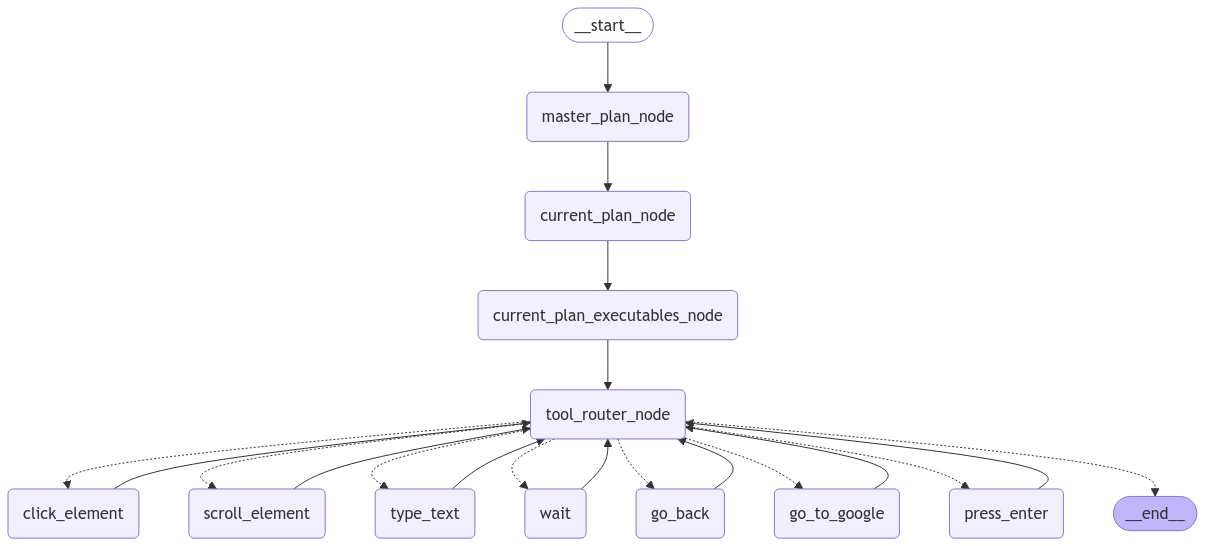

In [39]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

builder.add_node("master_plan_node", master_plan_node)
builder.add_node("current_plan_node", current_plan_node)
builder.add_node("current_plan_executables_node", current_plan_executables_node) 
builder.add_node("tool_router_node", tool_router_noder)
builder.add_node("click_element", click_element)
builder.add_node("scroll_element", scroll_element)
builder.add_node("type_text", type_text)
builder.add_node("wait", wait)
builder.add_node("go_back", go_back)
builder.add_node("go_to_google", go_to_google)
builder.add_node("press_enter", press_enter)


builder.add_edge(START, "master_plan_node")
builder.add_edge("master_plan_node", "current_plan_node")
builder.add_edge("current_plan_node", "current_plan_executables_node")
builder.add_edge("current_plan_executables_node", "tool_router_node")
builder.add_conditional_edges("tool_router_node", should_call_tool, ["click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "press_enter", END])

builder.add_edge("click_element", "tool_router_node")
builder.add_edge("scroll_element", "tool_router_node")
builder.add_edge("type_text", "tool_router_node")
builder.add_edge("wait", "tool_router_node")
builder.add_edge("go_back", "tool_router_node")
builder.add_edge("go_to_google", "tool_router_node")
builder.add_edge("press_enter", "tool_router_node")


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
async def setup_browser(go_to_page: str):
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    page = await browser.new_page()
    try:
        # Increase timeout to 80 seconds and add wait_until option
        await page.goto(go_to_page, timeout=80000, wait_until="domcontentloaded")
    except Exception as e:
        print(f"Error loading page: {e}")
        # Fallback to Google if the original page fails to load
        await page.goto("https://www.google.com", timeout=60000, wait_until="domcontentloaded")
    return playwright, browser, page



async def call_agent(task: str, go_to_page: str, max_steps: int = 250):
    playwright, browser, page = await setup_browser(go_to_page)
    final_answer = None
    event_stream = graph.astream(
        {
            "task": task, 
            "page": page, 
            "last_tool_action": ""
        }, 
        {
            "recursion_limit": max_steps
        },
        stream_mode="values"
    )

    try:
        async for event in event_stream:
            print(event)
            if "execute_current_plan_node" in event:
                final_answer = event["execute_current_plan_node"]
                print("\nFinal Answer:", final_answer)
                break
            

    finally:
        await browser.close()
        await playwright.stop()
        return final_answer

task = "Apple Stock News"
go_to_page = "https://edition.cnn.com/markets/stocks/AAPL"

final_answer = await call_agent(task, go_to_page)




{'messages': [], 'task': 'Apple Stock News', 'page': <Page url='https://edition.cnn.com/markets/stocks/AAPL'>, 'last_tool_action': '', 'notes': []}
********************MASTER PLAN NODE********************

----------------------------------------------------------

Agent State: {'messages': [], 'task': 'Apple Stock News', 'page': <Page url='https://edition.cnn.com/markets/stocks/AAPL'>, 'last_tool_action': '', 'notes': []}
----------------------------------------------------------

{'messages': [], 'task': 'Apple Stock News', 'page': <Page url='https://edition.cnn.com/markets/stocks/AAPL'>, 'master_plan': [{'plan': ['Scroll through the current page to identify any sections or articles related to Apple stock news.', 'Look for headlines or links that mention Apple or its stock performance.', "If there is a search bar available, type 'Apple stock news' and press enter to find specific articles.", "Click on any relevant articles to read the latest news about Apple's stock.", "Summarize the